In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler

In [2]:
df_cleaned = pd.read_csv("combined_data.csv", parse_dates=["timestamp"])

# Check schema and sample records
print("Schema:\n", df_cleaned.dtypes)
print("\nSample Records:\n", df_cleaned.head())

Schema:
 timestamp      datetime64[ns]
city                   object
temperature           float64
humidity              float64
windSpeed             float64
demand_mwh            float64
dtype: object

Sample Records:
             timestamp       city  temperature  humidity  windSpeed  demand_mwh
0 2018-07-01 07:00:00         la        65.45      0.79       4.23      9353.0
1 2018-07-01 07:00:00    phoenix        86.82      0.16       4.30      2764.0
2 2018-07-01 07:00:00  san diego        61.71      0.80       3.53      1737.0
3 2018-07-01 07:00:00   san jose        67.78      0.60       6.36     10653.0
4 2018-07-01 07:00:00    seattle        59.32      0.86       4.81       774.0


In [3]:
# Check for missing values
missing_summary = df_cleaned.isnull().sum()
print("Missing Values:\n", missing_summary)


df_cleaned['temperature'].fillna(df_cleaned['temperature'].mean(), inplace=True)
df_cleaned['humidity'].fillna(df_cleaned['humidity'].median(), inplace=True)
df_cleaned['windSpeed'].fillna(df_cleaned['windSpeed'].mean(), inplace=True)
df_cleaned.dropna(subset=["demand_mwh"], inplace=True)

Missing Values:
 timestamp         0
city              0
temperature      10
humidity         10
windSpeed        53
demand_mwh     4845
dtype: int64


C:\Users\Capricon\AppData\Local\Temp\ipykernel_16488\1116166772.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['temperature'].fillna(df_cleaned['temperature'].mean(), inplace=True)
C:\Users\Capricon\AppData\Local\Temp\ipykernel_16488\1116166772.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

In [4]:
print("Missing Values After Imputation:\n", df_cleaned.isnull().sum())

Missing Values After Imputation:
 timestamp      0
city           0
temperature    0
humidity       0
windSpeed      0
demand_mwh     0
dtype: int64


In [5]:
# Extract time-based features
df_cleaned["hour"] = df_cleaned["timestamp"].dt.hour
df_cleaned["day_of_week"] = df_cleaned["timestamp"].dt.dayofweek
df_cleaned["month"] = df_cleaned["timestamp"].dt.month
df_cleaned["season"] = df_cleaned["month"] % 12 // 3 + 1  # 1=Winter, ..., 4=Fall

In [6]:

# Scale selected columns
scaler = StandardScaler()
df_cleaned[["temperature", "humidity", "windSpeed", "demand_mwh"]] = (
    scaler.fit_transform(
        df_cleaned[["temperature", "humidity", "windSpeed", "demand_mwh"]]
    )
)

In [7]:
# Add date column
df_cleaned["date"] = df_cleaned["timestamp"].dt.date

# Compute daily summary statistics
daily_summary = (
    df_cleaned.groupby(["city", "date"])
    .agg(
        {
            "temperature": "mean",
            "humidity": "mean",
            "windSpeed": "mean",
            "demand_mwh": ["mean", "max", "min", "std"],
        }
    )
    .reset_index()
)

daily_summary.head()

city        date temperature  humidity windSpeed demand_mwh            \
                             mean      mean      mean       mean       max   
0  dallas  2018-07-02    1.695062 -0.650770  0.433115   2.651302  3.614403   
1  dallas  2018-07-03    1.784861 -0.937906  0.230107   2.462465  3.614239   
2  dallas  2018-07-04    1.459652 -0.400194  0.538382   1.963926  2.812490   
3  dallas  2018-07-05    1.335716 -0.168652  0.085678   2.080077  3.273137   
4  dallas  2018-07-06    1.475731 -0.229887  0.050919   2.048572  3.097702   

                       
        min       std  
0  1.386383  0.825345  
1  1.341901  0.855254  
2  1.103542  0.628661  
3  0.913989  0.863169  
4  1.229691  0.614883

In [8]:
import numpy as np
from scipy import stats

z_scores = np.abs(
    stats.zscore(df_cleaned[["temperature", "humidity", "windSpeed", "demand_mwh"]])
)
z_thresh = 3
z_outliers = (z_scores > z_thresh).any(axis=1)
df_cleaned["anomaly_zscore"] = z_outliers


from sklearn.ensemble import IsolationForest

# Isolation Forest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)
anomaly_preds = iso_forest.fit_predict(
    df_cleaned[["temperature", "humidity", "windSpeed", "demand_mwh"]]
)
df_cleaned["anomaly_iso"] = anomaly_preds == -1

In [9]:
# Select anomalies using boolean indexing on the full DataFrame
anomalies = df_cleaned[(df_cleaned["anomaly_zscore"]) | (df_cleaned["anomaly_iso"])]

# Show number of anomalies
print(f"Total Anomalies Detected: {anomalies.shape[0]}")

# Show selected columns from the anomalies DataFrame
anomalies_display = anomalies[
    ["timestamp", "city", "temperature", "humidity", "windSpeed", "demand_mwh"]
]
anomalies_display.head()

Total Anomalies Detected: 3345


,timestamp,city,temperature,humidity,windSpeed,demand_mwh
202,2018-07-02 14:00:00,dallas,1.198073,0.212147,0.968313,3.205693
212,2018-07-02 15:00:00,dallas,1.440358,-0.109332,0.692160,3.412598
222,2018-07-02 16:00:00,dallas,1.628873,-0.430811,0.602985,3.542786
232,2018-07-02 17:00:00,dallas,1.786390,-0.706364,0.344092,3.603874
242,2018-07-02 18:00:00,dallas,1.982495,-1.073769,0.315326,3.614403


In [10]:
# Check value ranges of key columns in anomalies
anomalies.describe()

,timestamp,temperature,humidity,windSpeed,demand_mwh,hour,day_of_week,month,season
count,3345,3345.000000,3345.000000,3345.000000,3345.000000,3345.000000,3345.000000,3345.000000,3345.000000
mean,2019-05-09 03:33:41.165919232,0.492096,-0.583361,2.109328,1.161724,14.869058,2.909716,6.335426,2.495067
min,2018-07-02 14:00:00,-3.753912,-3.002643,-1.620622,-1.336356,0.000000,0.000000,1.000000,1.000000
25%,2018-12-21 08:00:00,-0.928725,-1.211546,0.602985,-0.303395,11.000000,1.000000,4.000000,2.000000
50%,2019-05-22 21:00:00,1.066492,-0.614513,2.887002,0.683799,17.000000,3.000000,7.000000,3.000000
75%,2019-09-15 15:00:00,1.843956,0.074370,3.387529,2.889410,20.000000,4.000000,8.000000,3.000000
max,2020-05-19 20:00:00,3.233144,1.589914,6.163443,19.806009,23.000000,6.000000,12.000000,4.000000
std,NaN,1.677934,1.002144,1.685345,1.599622,6.782080,1.922134,3.283898,1.058143


In [11]:
# Remove rows with impossible (non-physical) values
df_cleaned_cleaned = df_cleaned[
    (df_cleaned["humidity"] >= 0)
    & (df_cleaned["humidity"] <= 1)
    & (df_cleaned["windSpeed"] >= 0)
    & (df_cleaned["demand_mwh"] >= 0)
]

CLUSTERING TASKS

In [12]:
# Select relevant features for clustering
features = df_cleaned_cleaned[["temperature", "humidity", "windSpeed", "demand_mwh"]]

# Normalize for clustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

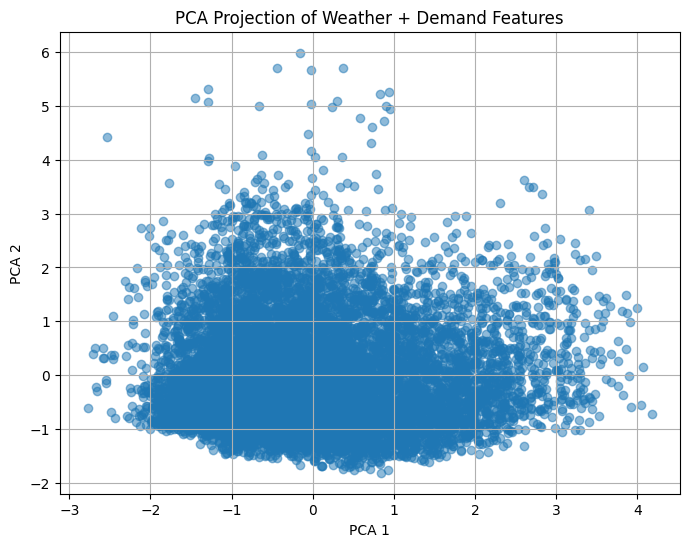

In [13]:
# PCA for visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title("PCA Projection of Weather + Demand Features")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

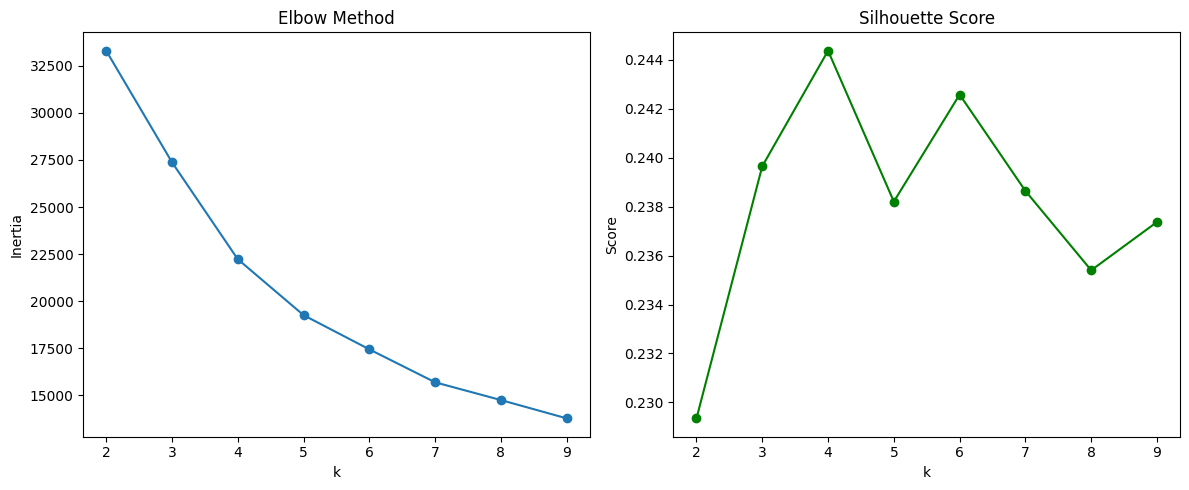

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow method to find optimal k
inertia = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow + Silhouette Score
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(K_range, inertia, marker="o")
ax[0].set_title("Elbow Method")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")

ax[1].plot(K_range, sil_scores, marker="o", color="green")
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Score")

plt.tight_layout()
plt.show()

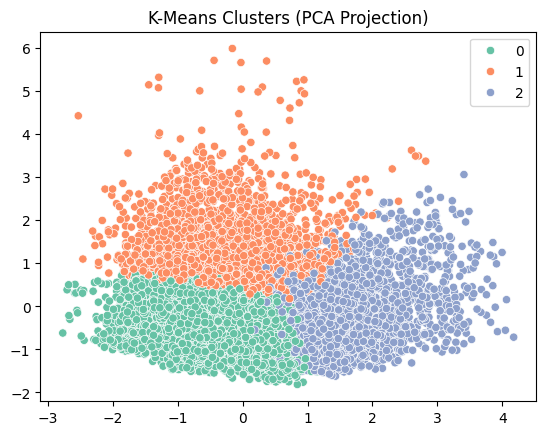

In [15]:
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42)
k_labels = kmeans.fit_predict(X_scaled)

# Visualize clusters in PCA space
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=k_labels, palette="Set2")
plt.title("K-Means Clusters (PCA Projection)")
plt.show()

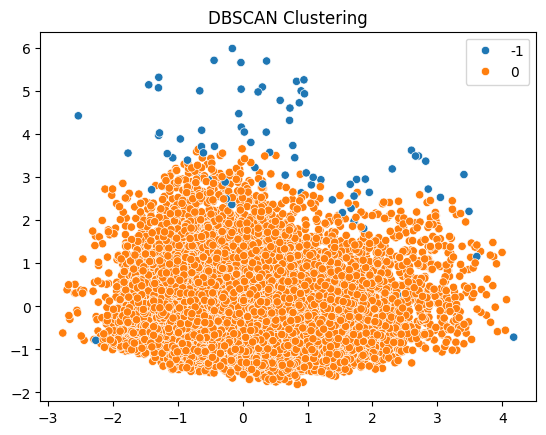

Noise points (label = -1): 80


In [16]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.7, min_samples=10)
db_labels = dbscan.fit_predict(X_scaled)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=db_labels, palette="tab10")
plt.title("DBSCAN Clustering")
plt.show()

# Count noise points
import numpy as np

print(f"Noise points (label = -1): {(db_labels == -1).sum()}")

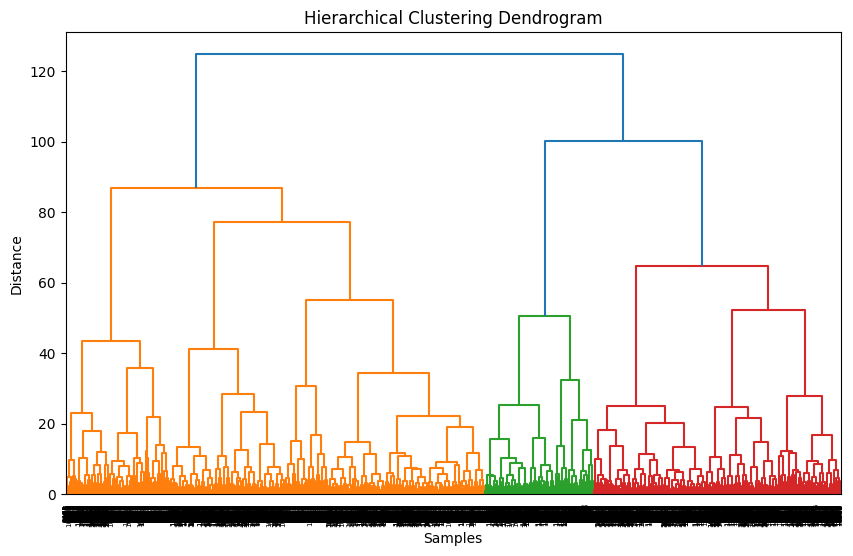

In [17]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method="ward"))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

In [18]:
# Silhouette Score
print("K-Means Silhouette Score:", silhouette_score(X_scaled, k_labels))
print("DBSCAN Silhouette Score:", silhouette_score(X_scaled, db_labels))

K-Means Silhouette Score: 0.23964832352207796
DBSCAN Silhouette Score: 0.4339154101721141


In [19]:
# Append K-Means labels for analysis
df_cleaned_cleaned["cluster"] = k_labels

# Group by cluster to analyze patterns
cluster_summary = df_cleaned_cleaned.groupby("cluster").agg(
    {
        "temperature": "mean",
        "humidity": "mean",
        "windSpeed": "mean",
        "demand_mwh": ["mean", "count"],
    }
)
cluster_summary

C:\Users\Capricon\AppData\Local\Temp\ipykernel_16488\3719583435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_cleaned["cluster"] = k_labels


temperature  humidity windSpeed demand_mwh      
               mean      mean      mean       mean count
cluster                                                 
0         -0.033814  0.560233  0.542164   0.667931  5853
1         -0.214259  0.550142  2.068900   0.896350  2383
2          1.214775  0.386974  0.892292   1.703354  2339

Predictive Modeling

In [20]:
import pandas as pd
import numpy as np

df = df_cleaned.copy()

df.drop(["anomaly_zscore", "anomaly_iso"], axis=1, inplace=True)
df.head()

,timestamp,city,temperature,humidity,windSpeed,demand_mwh,hour,day_of_week,month,season,date
0,2018-07-01 07:00:00,la,0.159978,0.625477,-0.472861,0.442668,7,6,7,3,2018-07-01
1,2018-07-01 07:00:00,phoenix,1.511842,-2.267834,-0.452725,-0.943237,7,6,7,3,2018-07-01
2,2018-07-01 07:00:00,san diego,-0.076614,0.671403,-0.674223,-1.159253,7,6,7,3,2018-07-01
3,2018-07-01 07:00:00,san jose,0.307373,-0.247109,0.139854,0.716105,7,6,7,3,2018-07-01
4,2018-07-01 07:00:00,seattle,-0.227805,0.946956,-0.306019,-1.361807,7,6,7,3,2018-07-01


In [21]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by timestamp
df = df.sort_values("timestamp")

# One-hot encode 'city'
df_encoded = pd.get_dummies(df, columns=["city"], drop_first=True)

# Drop unused columns
X = df_encoded.drop(columns=["demand_mwh", "timestamp", "date"])
y = df_encoded["demand_mwh"]

# Chronological time-based split (e.g., 80% train, 20% test)
split_index = int(0.8 * len(df_encoded))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

LINEAR REGRESSION

In [22]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Linear Regression")
mselinear= mean_squared_error(y_test, y_pred_lr)
mae_linear= mean_absolute_error(y_test, y_pred_lr)
r2_linear= r2_score(y_test, y_pred_lr)

print("MSE : ", mselinear)
print("MAE : ", mae_linear)
print("R2 : ", r2_linear)

Linear Regression
MSE :  0.1208956849319797
MAE :  0.25681442070827737
R2 :  0.8316223195100508


RANDOMFOREST

In [23]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest")
mserf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("MSE : ", mserf)
print("MAE : ", mae_rf)
print("R2 : ", r2_rf)

Random Forest
MSE :  0.040843570688340235
MAE :  0.10100802294771791
R2 :  0.9431150441862393


GRID SEARCH WITH RANDOM FOREST

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Use 5-fold time series split
tscv = TimeSeriesSplit(n_splits=5)

# Define model
rf = RandomForestRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
}

# Grid Search with TimeSeriesSplit
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

# Run grid search
grid_search_rf.fit(X_train, y_train)

# Best model and score
print("Best RF Params:", grid_search_rf.best_params_)
print("Best RF CV MSE:", -grid_search_rf.best_score_)

# Evaluate on test set
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RF Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best RF CV MSE: 0.04121627278697644


XGBOOST

In [25]:
xg_model = xgb.XGBRegressor(random_state=42)
xg_model.fit(X_train, y_train)
y_pred_xg = xg_model.predict(X_test)

print("XGBoost")
msexg = mean_squared_error(y_test, y_pred_xg)
mae_xg = mean_absolute_error(y_test, y_pred_xg)
r2_xg = r2_score(y_test, y_pred_xg)

print("MSE : ", msexg)
print("MAE : ", mae_xg)
print("R2 : ", r2_xg)

XGBoost
MSE :  0.039161755057190197
MAE :  0.10375412743632996
R2 :  0.9454573959016385


GRID SEARCH WITH XGBOOST

In [26]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xg = xgb.XGBRegressor(random_state=42, objective="reg:squarederror")

param_grid_xg = {
    "n_estimators": [50, 100],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1],
}

grid_search_xg = GridSearchCV(
    estimator=xg,
    param_grid=param_grid_xg,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

grid_search_xg.fit(X_train, y_train)

print("Best XGBoost Params:", grid_search_xg.best_params_)
print("Best XGBoost CV MSE:", -grid_search_xg.best_score_)

y_pred_xg = grid_search_xg.best_estimator_.predict(X_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best XGBoost CV MSE: 0.05764653639030395


In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")

# One-hot encode 'city'
df_encoded = pd.get_dummies(df, columns=["city"], drop_first=True)

# Drop non-numeric columns
features = df_encoded.drop(columns=["demand_mwh", "timestamp", "date"])
target = df_encoded["demand_mwh"]

# Normalize features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

# Prepare train-test split (time-based)
split_index = int(0.8 * len(df_encoded))
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

In [28]:
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i - window_size : i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)


# Set time window
window_size = 24  # e.g., 24 hours
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

In [29]:
# LSTM Model
# Define LSTM model
model_lstm = Sequential(
    [
        LSTM(64, input_shape=(window_size, X_train.shape[1]), return_sequences=False),
        Dense(32, activation="relu"),
        Dense(1),
    ]
)
model_lstm.compile(optimizer=Adam(0.001), loss="mse")

# Train LSTM
model_lstm.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.1)

C:\Users\Capricon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 77s 21ms/step - loss: 0.0019 - val_loss: 5.5206e-04
Epoch 2/10
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - loss: 7.1610e-04 - val_loss: 5.8303e-04
Epoch 3/10
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 5.2959e-04 - val_loss: 3.6417e-04
Epoch 4/10
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 4.3317e-04 - val_loss: 2.5846e-04
Epoch 5/10
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 73s 20ms/step - loss: 3.7455e-04 - val_loss: 2.3568e-04
Epoch 6/10
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - loss: 3.3910e-04 - val_loss: 2.3186e-04
Epoch 7/10
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 3.1346e-04 - val_loss: 2.2907e-04
Epoch 8/10
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 2.8812e-04 - val_loss: 1.9787e-04
Epoch 9/10
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 2.7140e-04 - val_loss: 1.8605e-04
Epoch 10/10
3620/3620 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 2.5458e-04 - val_loss: 1.7606e-04


In [30]:
# Predict and evaluate
y_pred_lstm = model_lstm.predict(X_test_seq)
y_pred_lstm_inv = scaler_y.inverse_transform(y_pred_lstm)
y_test_inv = scaler_y.inverse_transform(y_test_seq)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


print("LSTM Performance")

mselstm = mean_squared_error(y_test_inv, y_pred_lstm_inv)
maelstm = mean_absolute_error(y_test_inv, y_pred_lstm_inv)
r2lstm = r2_score(y_test_inv, y_pred_lstm_inv)

print("MSE: ", mselstm)
print("MAE: ", maelstm)
print("R2: ", r2lstm)


1005/1005 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
LSTM Performance
MSE:  0.25574835333281676
MAE:  0.281378499506755
R2:  0.6438497590858459


Baseline Comparison:

In [31]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Reset index to ensure consistent shifting
df_sorted = df.sort_values("timestamp").reset_index(drop=True)

# Naive forecast: use previous day's same hour demand
df_sorted["naive_forecast"] = df_sorted["demand_mwh"].shift(24)

df_naive = df_sorted.dropna(subset=["naive_forecast"])

# MAE
mae_naive = mean_absolute_error(df_naive["demand_mwh"], df_naive["naive_forecast"])

# RMSE (Note: squared=False only works in sklearn >=0.22)
rmse_naive = mean_squared_error(
    df_naive["demand_mwh"], df_naive["naive_forecast"]
)

# MAPE - handle divide-by-zero issues by filtering out near-zero actual values
df_filtered = df_naive[df_naive["demand_mwh"] > 1.0]  # Adjust threshold if needed
mape_naive = (
    np.mean(
        np.abs(
            (df_filtered["demand_mwh"] - df_filtered["naive_forecast"])
            / df_filtered["demand_mwh"]
        )
    )
    * 100
)

# SMAPE (optional but more stable)
smape = 100 * np.mean(
    2
    * np.abs(df_naive["naive_forecast"] - df_naive["demand_mwh"])
    / (np.abs(df_naive["naive_forecast"]) + np.abs(df_naive["demand_mwh"]))
)

# Print results
print("Naive Forecast Performance:")
print(f"MAE: {mae_naive}")
print(f"RMSE: {rmse_naive}")
print(f"MAPE (filtered): {mape_naive}")
print(f"SMAPE: {smape}")

Naive Forecast Performance:
MAE: 1.1290381163638183
RMSE: 1.9815400665026046
MAPE (filtered): 104.40509363054042
SMAPE: 134.52190110373638


ENSEMBLE LEARNING

In [32]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Define base learners and meta-learner
base_models = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xg', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
]

meta_model = LinearRegression()

# Create stacking model
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, n_jobs=-1)

# Fit stacking model
stacked_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_stack = stacked_model.predict(X_test)

print("Stacked Model Performance")
print("MSE:", mean_squared_error(y_test, y_pred_stack))
print("MAE:", mean_absolute_error(y_test, y_pred_stack))
print("R2:", r2_score(y_test, y_pred_stack))


C:\Users\Capricon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_stacking.py:1060: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Stacked Model Performance
MSE: 8.518709691697868e-05
MAE: 0.00465217171957406
R2: 0.944582122866838


In [33]:
from sklearn.metrics import mean_absolute_percentage_error
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_stack))

MAPE: 0.05713591138782119


ARIMA SARIMA

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)


df_arima_clean = pd.read_csv("combined_data.csv")

df_arima_clean["temperature"].fillna(df_arima_clean["temperature"].mean(), inplace=True)
df_arima_clean["humidity"].fillna(df_arima_clean["humidity"].median(), inplace=True)
df_arima_clean["windSpeed"].fillna(df_arima_clean["windSpeed"].mean(), inplace=True)
df_arima_clean.dropna(subset=["demand_mwh"], inplace=True)
df_arima_clean = df_arima_clean[
    df_arima_clean["demand_mwh"] >= 0
]  # Remove negative demand values

# Ensure timestamp is datetime
df_arima_clean["timestamp"] = pd.to_datetime(df_arima_clean["timestamp"])

C:\Users\Capricon\AppData\Local\Temp\ipykernel_16488\1708791166.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_arima_clean["temperature"].fillna(df_arima_clean["temperature"].mean(), inplace=True)
C:\Users\Capricon\AppData\Local\Temp\ipykernel_16488\1708791166.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

In [35]:
def train_arima_models(df):
    cities = df["city"].unique()
    arima_results = {}

    for city in cities:
        city_df = df[df["city"] == city].sort_values("timestamp")
        demand_series = city_df["demand_mwh"].values

        # Train/test split (e.g., last 20% as test)
        split_idx = int(0.8 * len(demand_series))
        train, test = demand_series[:split_idx], demand_series[split_idx:]

        # Fit ARIMA
        try:
            model = ARIMA(train, order=(5, 1, 0))
            fit = model.fit()
            forecast = fit.forecast(steps=len(test))
        except Exception as e:
            print(f"ARIMA failed for {city}: {e}")
            continue

        # Metrics
        mae = mean_absolute_error(test, forecast)
        rmse = mean_squared_error(test, forecast)
        mape = np.mean(np.abs((test - forecast) / test)) * 100

        arima_results[city] = {
            "MAE": round(mae, 4),
            "RMSE": round(rmse, 4),
            "MAPE": round(mape, 2),
        }

    return arima_results

In [36]:
print("Training ARIMA models...\n")
arima_results = train_arima_models(df_arima_clean)
print("ARIMA Results:")
for city, metrics in arima_results.items():
    print(
        f"{city}: MAE={metrics['MAE']}, RMSE={metrics['RMSE']}, MAPE={metrics['MAPE']}%"
    )

Training ARIMA models...

ARIMA Results:
la: MAE=1112.1324, RMSE=2057700.7029, MAPE=10.75%
phoenix: MAE=664.3316, RMSE=3663202.9299, MAPE=21.63%
san diego: MAE=359.0088, RMSE=190553.9907, MAPE=22.71%
san jose: MAE=1013.952, RMSE=1735297.855, MAPE=9.37%
seattle: MAE=186.0527, RMSE=54349.4815, MAPE=18.24%
nyc: MAE=1254.9178, RMSE=2100343.0664, MAPE=27.73%
philadelphia: MAE=480.7835, RMSE=348109.977, MAPE=12.39%
dallas: MAE=2405.2515, RMSE=7921136.2443, MAPE=22.94%
houston: MAE=1284.849, RMSE=2585229.9007, MAPE=11.93%
san antonio: MAE=1025.3438, RMSE=1514154.3758, MAPE=18.47%


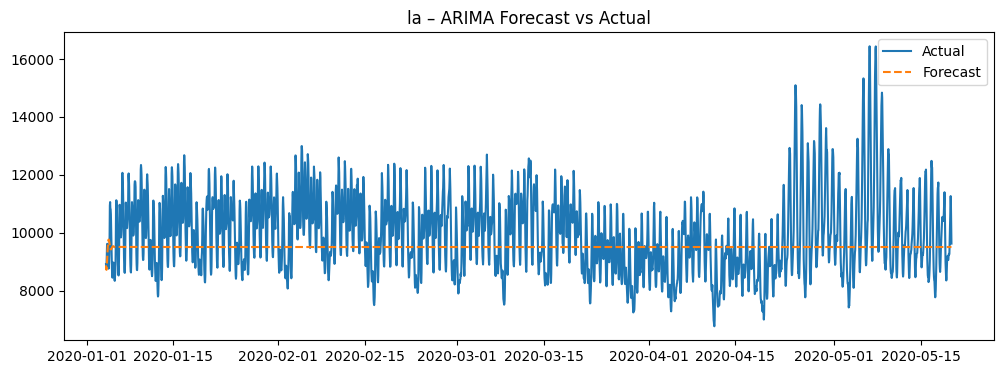

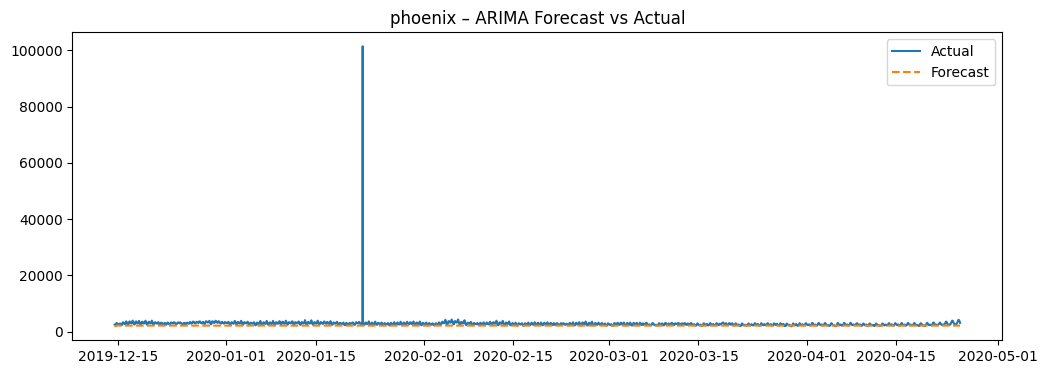

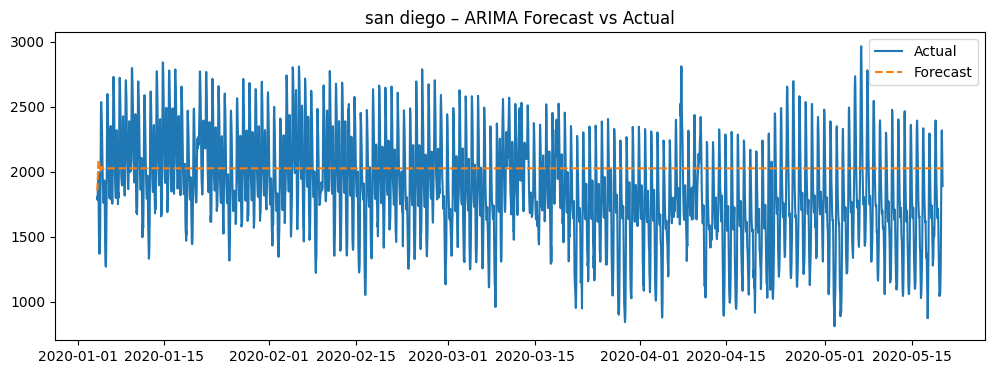

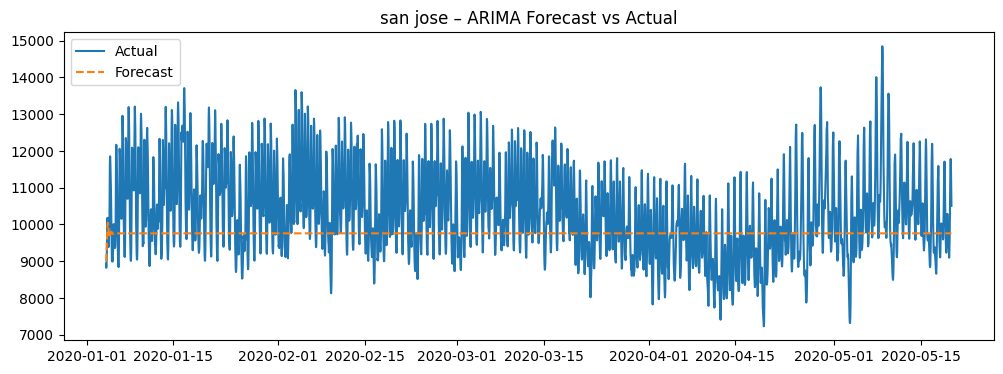

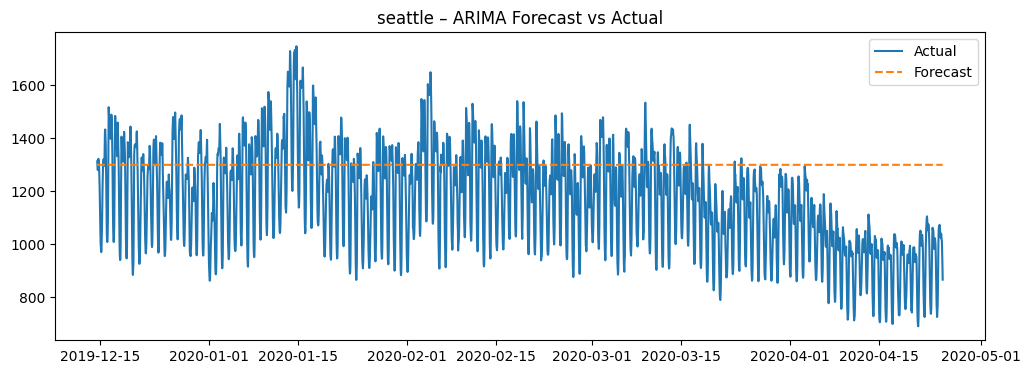

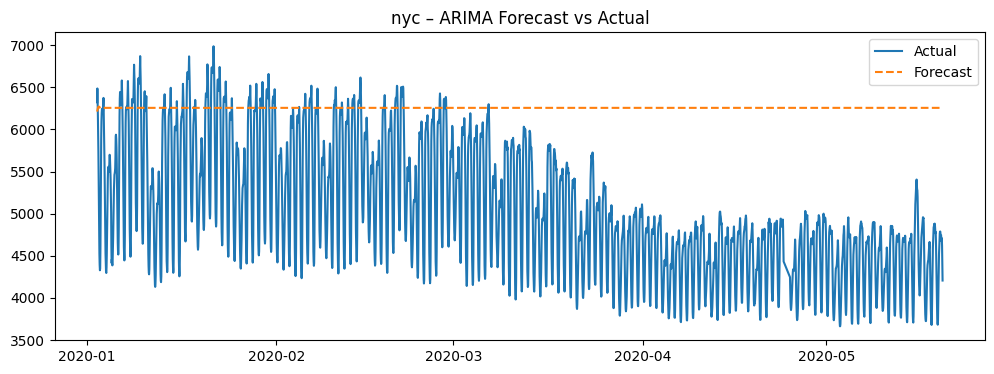

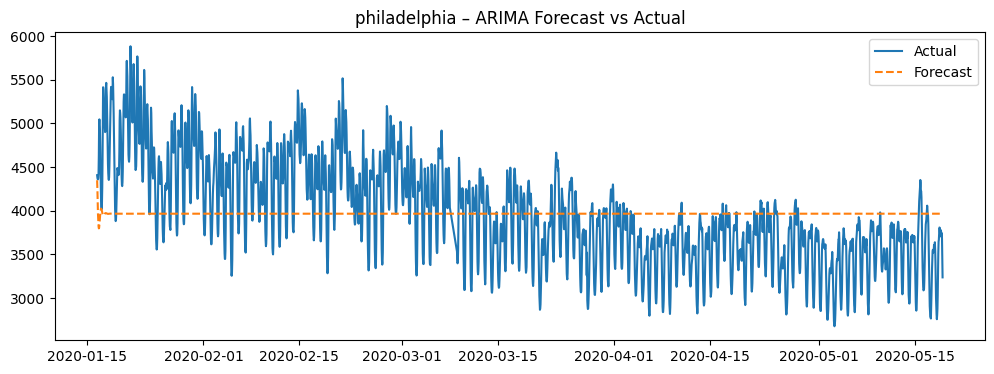

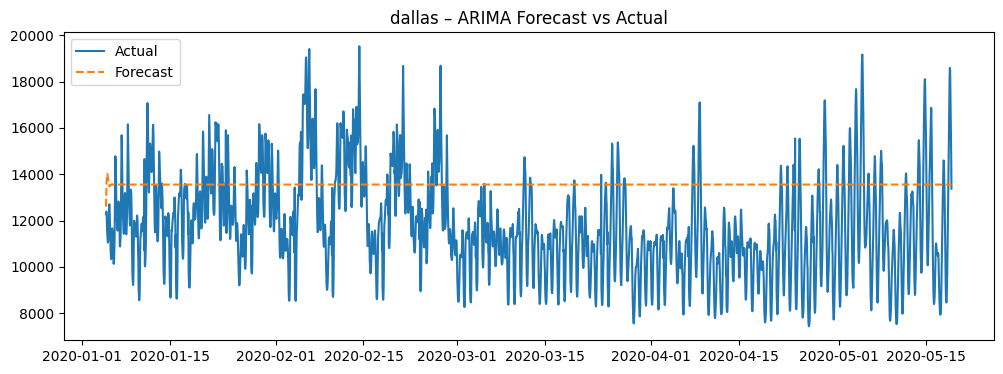

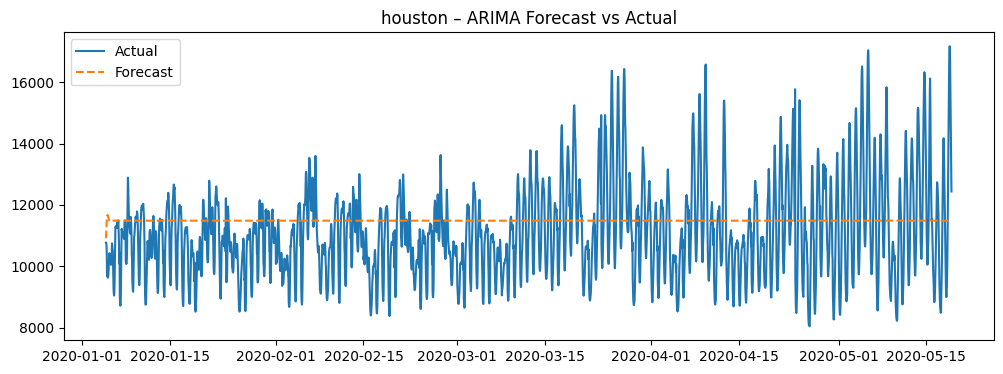

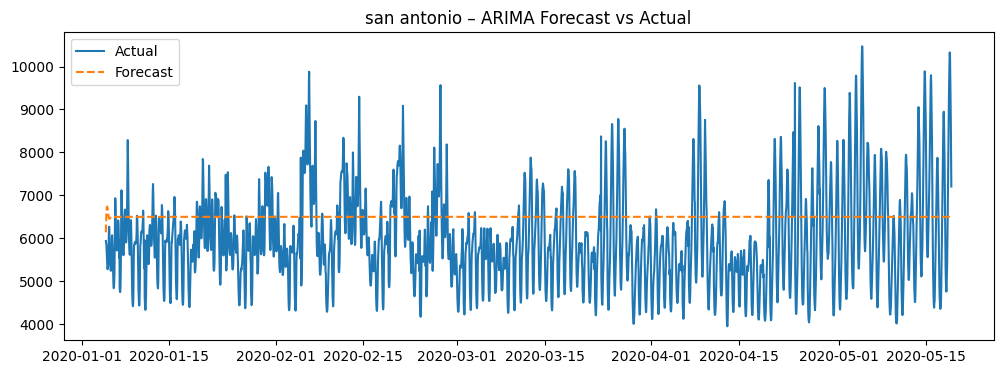

In [37]:
import matplotlib.pyplot as plt


def plot_forecast(city_name, df):
    city_df = df[df["city"] == city_name].sort_values("timestamp")
    demand_series = city_df["demand_mwh"].values

    split_idx = int(0.8 * len(demand_series))
    train, test = demand_series[:split_idx], demand_series[split_idx:]

    model = ARIMA(train, order=(5, 1, 0))
    fit = model.fit()
    forecast = fit.forecast(steps=len(test))

    plt.figure(figsize=(12, 4))
    plt.plot(city_df["timestamp"].values[split_idx:], test, label="Actual")
    plt.plot(
        city_df["timestamp"].values[split_idx:],
        forecast,
        label="Forecast",
        linestyle="--",
    )
    plt.title(f"{city_name} – ARIMA Forecast vs Actual")
    plt.legend()
    plt.show()


plot_forecast("la", df_arima_clean)
plot_forecast("phoenix", df_arima_clean)
plot_forecast("san diego", df_arima_clean)
plot_forecast("san jose", df_arima_clean)
plot_forecast("seattle", df_arima_clean)
plot_forecast("nyc", df_arima_clean)
plot_forecast("philadelphia", df_arima_clean)
plot_forecast("dallas", df_arima_clean)
plot_forecast("houston", df_arima_clean)
plot_forecast("san antonio", df_arima_clean)

In [38]:
def train_sarima_models(df):
    cities = df["city"].unique()
    sarima_results = {}

    for city in cities:
        city_df = df[df["city"] == city].sort_values("timestamp")
        demand_series = city_df["demand_mwh"].values

        # Train/test split (e.g., last 20% as test)
        split_idx = int(0.8 * len(demand_series))
        train, test = demand_series[:split_idx], demand_series[split_idx:]

        # Fit SARIMA
        try:
            model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
            fit = model.fit(disp=False)
            forecast = fit.forecast(steps=len(test))
        except Exception as e:
            print(f"SARIMA failed for {city}: {e}")
            continue

        # Metrics
        mae = mean_absolute_error(test, forecast)
        rmse = mean_squared_error(test, forecast)
        mape = np.mean(np.abs((test - forecast) / test)) * 100

        sarima_results[city] = {
            "MAE": round(mae, 4),
            "RMSE": round(rmse, 4),
            "MAPE": round(mape, 2),
        }

    return sarima_results

In [39]:
print("\nTraining SARIMA models...\n")
sarima_results = train_sarima_models(df_arima_clean)
print("SARIMA Results:")
for city, metrics in sarima_results.items():
    print(
        f"{city}: MAE={metrics['MAE']}, RMSE={metrics['RMSE']}, MAPE={metrics['MAPE']}%"
    )


Training SARIMA models...



C:\Users\Capricon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA Results:
la: MAE=2309.7507, RMSE=8324142.7285, MAPE=22.7%
phoenix: MAE=2462.7055, RMSE=10437147.5576, MAPE=93.65%
san diego: MAE=206.0859, RMSE=75168.3135, MAPE=11.81%
san jose: MAE=3187.2546, RMSE=13536539.8439, MAPE=31.07%
seattle: MAE=135.8912, RMSE=26891.1968, MAPE=11.36%
nyc: MAE=3685.3749, RMSE=18341868.5687, MAPE=79.3%
philadelphia: MAE=1487.5694, RMSE=2573455.9351, MAPE=39.42%
dallas: MAE=10323.1771, RMSE=135423501.4414, MAPE=90.46%
houston: MAE=6210.1242, RMSE=50495752.2235, MAPE=55.01%
san antonio: MAE=6185.68, RMSE=50196075.7724, MAPE=103.81%
